<a href="https://colab.research.google.com/github/WoojinJeonkr/DeepLearning/blob/main/FixRes_Fixing_train_test_resolution_discrepancy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FixRes: 훈련 테스트 해상도 불일치 수정
- 내용 출처: [FixRes: 훈련 테스트 해상도 불일치 수정](https://keras.io/examples/vision/fixres/)
- 목표: 훈련 세트와 테스트 세트 간의 해상도 불일치 완화
- Touvron et al.에 의해 도입된 FixRes 기술 구현

## 01. 라이브러리 불러오기

In [1]:
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf

import tensorflow_datasets as tfds

tfds.disable_progress_bar()

import matplotlib.pyplot as plt

## 02. tf_flowers 데이터세트 다운로드

In [2]:
train_dataset, val_dataset = tfds.load(
    "tf_flowers", split=["train[:90%]", "train[90%:]"], as_supervised=True
)

num_train = train_dataset.cardinality()
num_val = val_dataset.cardinality()
print(f"Number of training examples: {num_train}")
print(f"Number of validation examples: {num_val}")

Dataset tf_flowers downloaded and prepared to ~/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.
Number of training examples: 3303
Number of validation examples: 367


## 03. 데이터 전처리

In [3]:
batch_size = 128
auto = tf.data.AUTOTUNE
smaller_size = 128
bigger_size = 224

size_for_resizing = int((bigger_size / smaller_size) * bigger_size)
central_crop_layer = layers.CenterCrop(bigger_size, bigger_size)

In [4]:
def preprocess_initial(train, image_size):
    def _pp(image, label, train):
        if train:
            channels = image.shape[-1]
            begin, size, _ = tf.image.sample_distorted_bounding_box(
                tf.shape(image),
                tf.zeros([0, 0, 4], tf.float32),
                area_range=(0.05, 1.0),
                min_object_covered=0,
                use_image_if_no_bounding_boxes=True,
            )
            image = tf.slice(image, begin, size)

            image.set_shape([None, None, channels])
            image = tf.image.resize(image, [image_size, image_size])
            image = tf.image.random_flip_left_right(image)
        else:
            image = tf.image.resize(image, [image_size, image_size])

        return image, label

    return _pp

In [5]:
def preprocess_finetune(image, label, train):
    image = tf.image.resize(image, [size_for_resizing, size_for_resizing])
    if train:
        image = tf.image.random_flip_left_right(image)
    image = central_crop_layer(image[None, ...])[0]

    return image, label

In [6]:
def make_dataset(
    dataset: tf.data.Dataset,
    train: bool,
    image_size: int = smaller_size,
    fixres: bool = True,
    num_parallel_calls=auto,
):
    if image_size not in [smaller_size, bigger_size]:
        raise ValueError(f"{image_size} resolution is not supported.")

    if image_size == smaller_size:
        preprocess_func = preprocess_initial(train, image_size)
    elif not fixres and image_size == bigger_size:
        preprocess_func = preprocess_initial(train, image_size)
    else:
        preprocess_func = preprocess_finetune

    if train:
        dataset = dataset.shuffle(batch_size * 10)

    return (
        dataset.map(
            lambda x, y: preprocess_func(x, y, train),
            num_parallel_calls=num_parallel_calls,
        )
        .batch(batch_size)
        .prefetch(num_parallel_calls)
    )

## 04. 데이터세트 준비하기

In [7]:
initial_train_dataset = make_dataset(train_dataset, train=True, image_size=smaller_size)
initial_val_dataset = make_dataset(val_dataset, train=False, image_size=smaller_size)

finetune_train_dataset = make_dataset(train_dataset, train=True, image_size=bigger_size)
finetune_val_dataset = make_dataset(val_dataset, train=False, image_size=bigger_size)

vanilla_train_dataset = make_dataset(
    train_dataset, train=True, image_size=bigger_size, fixres=False
)
vanilla_val_dataset = make_dataset(
    val_dataset, train=False, image_size=bigger_size, fixres=False
)

## 05. 데이터세트 시각화

In [8]:
def visualize_dataset(batch_images):
    plt.figure(figsize=(10, 10))
    for n in range(25):
        ax = plt.subplot(5, 5, n + 1)
        plt.imshow(batch_images[n].numpy().astype("int"))
        plt.axis("off")
    plt.show()

    print(f"Batch shape: {batch_images.shape}.")

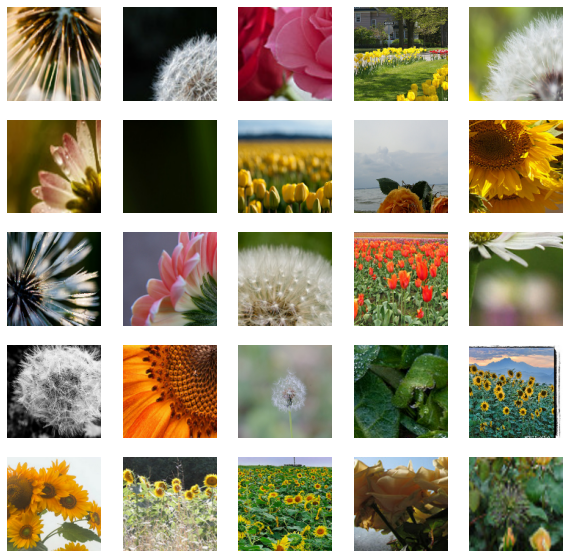

Batch shape: (128, 128, 128, 3).


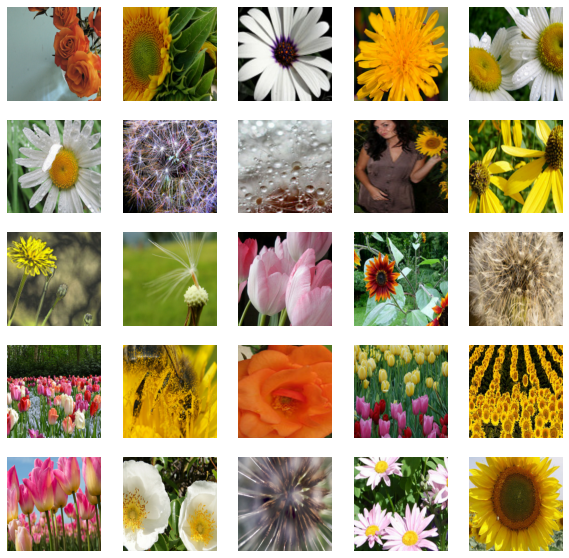

Batch shape: (128, 224, 224, 3).


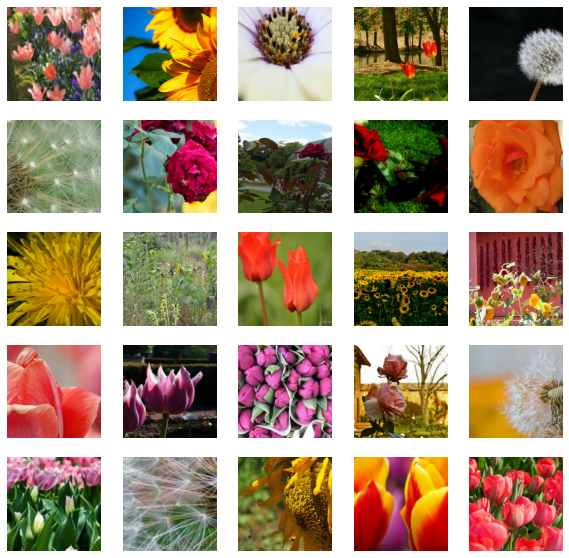

Batch shape: (128, 224, 224, 3).


In [9]:
initial_sample_images, _ = next(iter(initial_train_dataset))
visualize_dataset(initial_sample_images)

finetune_sample_images, _ = next(iter(finetune_train_dataset))
visualize_dataset(finetune_sample_images)

vanilla_sample_images, _ = next(iter(vanilla_train_dataset))
visualize_dataset(vanilla_sample_images)

## 06. 모델 훈련

In [10]:
def get_training_model(num_classes=5):
    inputs = layers.Input((None, None, 3))
    resnet_base = keras.applications.ResNet50V2(
        include_top=False, weights=None, pooling="avg"
    )
    resnet_base.trainable = True

    x = layers.Rescaling(scale=1.0 / 127.5, offset=-1)(inputs)
    x = resnet_base(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    return keras.Model(inputs, outputs)

In [11]:
def train_and_evaluate(
    model, train_ds, val_ds, epochs, learning_rate=1e-3, use_early_stopping=False
):
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(
        optimizer=optimizer,
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )

    if use_early_stopping:
        es_callback = keras.callbacks.EarlyStopping(patience=5)
        callbacks = [es_callback]
    else:
        callbacks = None

    model.fit(
        train_ds, validation_data=val_ds, epochs=epochs, callbacks=callbacks,
    )

    _, accuracy = model.evaluate(val_ds)
    print(f"Top-1 accuracy on the validation set: {accuracy*100:.2f}%.")
    return model

In [12]:
epochs = 10

smaller_res_model = get_training_model()
smaller_res_model = train_and_evaluate(
    smaller_res_model, initial_train_dataset, initial_val_dataset, epochs
)

Epoch 1/10
26/26 [==============================] - 669s 25s/step - loss: 1.5269 - accuracy: 0.4296 - val_loss: 1.5027 - val_accuracy: 0.3678
Epoch 2/10
26/26 [==============================] - 673s 26s/step - loss: 1.1901 - accuracy: 0.5428 - val_loss: 1.8981 - val_accuracy: 0.2016
Epoch 3/10
26/26 [==============================] - 668s 26s/step - loss: 1.0663 - accuracy: 0.5716 - val_loss: 2.0577 - val_accuracy: 0.2098
Epoch 4/10
26/26 [==============================] - 659s 25s/step - loss: 1.0327 - accuracy: 0.6052 - val_loss: 4.0228 - val_accuracy: 0.1935
Epoch 5/10
26/26 [==============================] - 665s 26s/step - loss: 0.9736 - accuracy: 0.6240 - val_loss: 2.8566 - val_accuracy: 0.2207
Epoch 6/10
26/26 [==============================] - 671s 26s/step - loss: 0.9844 - accuracy: 0.6167 - val_loss: 1.8374 - val_accuracy: 0.2943
Epoch 7/10
26/26 [==============================] - 667s 26s/step - loss: 0.9002 - accuracy: 0.6540 - val_loss: 1.9651 - val_accuracy: 0.4087
Epoch 

## 07. 최종 배치 정규화 층을 제외한 모든 층 고정

In [13]:
for layer in smaller_res_model.layers[2].layers:
    layer.trainable = False

smaller_res_model.layers[2].get_layer("post_bn").trainable = True

epochs = 10

bigger_res_model = train_and_evaluate(
    smaller_res_model,
    finetune_train_dataset,
    finetune_val_dataset,
    epochs,
    learning_rate=1e-4,
)

Epoch 1/10
26/26 [==============================] - 367s 14s/step - loss: 1.3948 - accuracy: 0.3718 - val_loss: 1.4068 - val_accuracy: 0.3569
Epoch 2/10
26/26 [==============================] - 357s 14s/step - loss: 1.3876 - accuracy: 0.3757 - val_loss: 1.3822 - val_accuracy: 0.3324
Epoch 3/10
26/26 [==============================] - 363s 14s/step - loss: 1.3840 - accuracy: 0.3706 - val_loss: 1.3791 - val_accuracy: 0.3270
Epoch 4/10
26/26 [==============================] - 361s 14s/step - loss: 1.3818 - accuracy: 0.3724 - val_loss: 1.3708 - val_accuracy: 0.3270
Epoch 5/10
26/26 [==============================] - 365s 14s/step - loss: 1.3777 - accuracy: 0.3748 - val_loss: 1.3683 - val_accuracy: 0.3297
Epoch 6/10
26/26 [==============================] - 374s 14s/step - loss: 1.3847 - accuracy: 0.3703 - val_loss: 1.3703 - val_accuracy: 0.3351
Epoch 7/10
26/26 [==============================] - 370s 14s/step - loss: 1.3829 - accuracy: 0.3748 - val_loss: 1.3749 - val_accuracy: 0.3243
Epoch 

## 08. 처음부터 224X224 해상도로 훈련하기

In [ ]:
epochs = 10

vanilla_bigger_res_model = get_training_model()
vanilla_bigger_res_model = train_and_evaluate(
    vanilla_bigger_res_model, vanilla_train_dataset, vanilla_val_dataset, epochs
)

Epoch 1/30
